In [18]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.model_selection import train_test_split

# A. Generate Data

In [19]:
#!Rscript generate_data.R --N_data=10000

# B. Train Model

In [20]:
class PhiThreshDataset(Dataset):
    def __init__(self, data_dir):
        self.phi_dir = os.path.join(data_dir, 'Phi_mat')
        self.beta_dir = os.path.join(data_dir, 'beta')
        self.v_thresh_dir = os.path.join(data_dir, 'v_thresh')
        
        self.phi_files = [f for f in os.listdir(self.phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
        self.beta_files = [f for f in os.listdir(self.beta_dir) if f.startswith('beta_') and f.endswith('.txt')]
        self.v_thresh_files = [f for f in os.listdir(self.v_thresh_dir) if f.startswith('v_thresh_') and f.endswith('.txt')]

    def __len__(self):
        return len(self.phi_files)

    def __getitem__(self, idx):
        phi_file = os.path.join(self.phi_dir, self.phi_files[idx])
        phi = np.loadtxt(phi_file)

        beta_file = os.path.join(self.beta_dir, self.beta_files[idx])
        beta = np.loadtxt(beta_file)
        
        v_thresh_file = os.path.join(self.v_thresh_dir, self.v_thresh_files[idx])
        v_thresh = np.loadtxt(v_thresh_file)

        return torch.tensor(phi, dtype=torch.float32), torch.tensor(beta, dtype=torch.float32), torch.tensor(v_thresh, dtype=torch.float32)

In [21]:
def get_data_loaders(data_dir, batch_size=32, test_size=0.2):
    dataset = PhiThreshDataset(data_dir)
    train_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=42)
    
    train_set = torch.utils.data.Subset(dataset, train_indices)
    test_set = torch.utils.data.Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_indices, test_indices

In [22]:
class PhiNet(nn.Module):
    def __init__(self, input_size):
        super(PhiNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = (torch.sigmoid(self.fc3(x)) + 1)*0.5 # Busquem el rang (0.5, 1)
        return x

In [23]:
def sigma_v(x, v, exponent=10):
    return 1 / (1 + torch.exp(-exponent*(x + v)))

def FDR_surr(v, Phi, beta):
    ones = torch.ones_like(Phi)
    term1 = sigma_v((1 - beta) * Phi, v)  # Hadamard product
    term2 = sigma_v(Phi, v)
    
    FDR_value = torch.sum(term1) / torch.sum(term2)
    
    return FDR_value

In [24]:
class CustomLoss(nn.Module):
    def __init__(self, alpha, lambda1=1.0, lambda2=1.0, lambda3=1.0):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.lambda3 = lambda3
        self.mse = nn.MSELoss()

    def forward(self, v_pred, v_true, Phi, beta, FDR_surr=None):
        mse_loss = self.mse(v_pred, v_true)
        
        if FDR_surr:
            FDR_hat = FDR_surr(v_pred, Phi, beta)
            larger_fdr_loss = torch.mean(torch.clamp(FDR_hat - self.alpha, min=0)**2)
            smaller_fdr_loss = torch.mean(torch.clamp(self.alpha - FDR_hat, min=0)**2)
        else:
            larger_fdr_loss = 0.0
            smaller_fdr_loss = 0.0
        
        loss = self.lambda1 * mse_loss + self.lambda2 * larger_fdr_loss + self.lambda3 * smaller_fdr_loss
        
        return loss

In [25]:
def evaluate_model(model, train_loader, test_loader, criterion, verbose=True):
    model.eval()
    losses_over_train = []
    with torch.no_grad():
        for Phis, betas, v_opt in train_loader:
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            losses_over_train.append(loss.item())
    if verbose:
        print(f'Train Loss: {sum(losses_over_train) / len(train_loader):.4f}')
    
    losses_over_test = []
    with torch.no_grad():
        for Phis, betas, v_opt in test_loader:
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            losses_over_test.append(loss.item())
    if verbose:
        print(f'Test Loss: {sum(losses_over_test) / len(test_loader):.4f}')
    
    return losses_over_train, losses_over_test

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", position=0)
        for _, (Phis, betas, v_opt) in progress_bar:
            optimizer.zero_grad()
            outputs = model(Phis)
            loss = criterion(outputs.squeeze(), v_opt, Phis, betas)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Running Loss: {running_loss / len(train_loader):.4f}')
        losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)
        train_losses.append(sum(losses_over_train) / len(train_loader))
        test_losses.append(sum(losses_over_test) / len(test_loader))
    return train_losses, test_losses

In [26]:
data_dir = 'data'
input_size = len(np.loadtxt(os.path.join(data_dir, 'Phi_mat/Phi_mat_1.txt')))

hparams = {"batch_size": 16,
           "learning_rate": 0.001,
           "num_epochs": 100}

train_loader, test_loader, train_indices, test_indices = get_data_loaders(data_dir, batch_size=hparams["batch_size"])

model = PhiNet(input_size=input_size)
# criterion = nn.MSELoss()
criterion = CustomLoss(0.1)
optimizer = optim.Adam(model.parameters(), lr=hparams["learning_rate"])

train_losses, test_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=hparams["num_epochs"])

Epoch 1/100: 100%|██████████| 500/500 [00:07<00:00, 69.80it/s]


Epoch [1/100], Running Loss: 0.0279
Train Loss: 0.0260
Test Loss: 0.0266


Epoch 2/100: 100%|██████████| 500/500 [00:03<00:00, 142.83it/s]


Epoch [2/100], Running Loss: 0.0244
Train Loss: 0.0215
Test Loss: 0.0227


Epoch 3/100: 100%|██████████| 500/500 [00:03<00:00, 128.50it/s]


Epoch [3/100], Running Loss: 0.0209
Train Loss: 0.0192
Test Loss: 0.0202


Epoch 4/100: 100%|██████████| 500/500 [00:04<00:00, 116.14it/s]


Epoch [4/100], Running Loss: 0.0196
Train Loss: 0.0186
Test Loss: 0.0198


Epoch 5/100: 100%|██████████| 500/500 [00:03<00:00, 144.15it/s]


Epoch [5/100], Running Loss: 0.0189
Train Loss: 0.0180
Test Loss: 0.0195


Epoch 6/100: 100%|██████████| 500/500 [00:03<00:00, 137.76it/s]


Epoch [6/100], Running Loss: 0.0184
Train Loss: 0.0174
Test Loss: 0.0196


Epoch 7/100: 100%|██████████| 500/500 [00:03<00:00, 148.57it/s]


Epoch [7/100], Running Loss: 0.0179
Train Loss: 0.0168
Test Loss: 0.0198


Epoch 8/100: 100%|██████████| 500/500 [00:03<00:00, 146.56it/s]


Epoch [8/100], Running Loss: 0.0173
Train Loss: 0.0163
Test Loss: 0.0202


Epoch 9/100: 100%|██████████| 500/500 [00:03<00:00, 149.21it/s]


Epoch [9/100], Running Loss: 0.0168
Train Loss: 0.0156
Test Loss: 0.0201


Epoch 10/100: 100%|██████████| 500/500 [00:03<00:00, 142.75it/s]


Epoch [10/100], Running Loss: 0.0163
Train Loss: 0.0151
Test Loss: 0.0205


Epoch 11/100: 100%|██████████| 500/500 [00:03<00:00, 137.30it/s]


Epoch [11/100], Running Loss: 0.0157
Train Loss: 0.0146
Test Loss: 0.0206


Epoch 12/100: 100%|██████████| 500/500 [00:07<00:00, 70.64it/s]


Epoch [12/100], Running Loss: 0.0151
Train Loss: 0.0140
Test Loss: 0.0206


Epoch 13/100: 100%|██████████| 500/500 [00:07<00:00, 70.85it/s]


Epoch [13/100], Running Loss: 0.0146
Train Loss: 0.0136
Test Loss: 0.0209


Epoch 14/100: 100%|██████████| 500/500 [00:06<00:00, 73.55it/s]


Epoch [14/100], Running Loss: 0.0140
Train Loss: 0.0129
Test Loss: 0.0211


Epoch 15/100: 100%|██████████| 500/500 [00:06<00:00, 75.39it/s]


Epoch [15/100], Running Loss: 0.0135
Train Loss: 0.0122
Test Loss: 0.0214


Epoch 16/100: 100%|██████████| 500/500 [00:06<00:00, 73.96it/s]


Epoch [16/100], Running Loss: 0.0130
Train Loss: 0.0121
Test Loss: 0.0226


Epoch 17/100: 100%|██████████| 500/500 [00:06<00:00, 75.02it/s]


Epoch [17/100], Running Loss: 0.0126
Train Loss: 0.0113
Test Loss: 0.0215


Epoch 18/100: 100%|██████████| 500/500 [00:06<00:00, 75.75it/s]


Epoch [18/100], Running Loss: 0.0121
Train Loss: 0.0109
Test Loss: 0.0225


Epoch 19/100: 100%|██████████| 500/500 [00:06<00:00, 74.55it/s]


Epoch [19/100], Running Loss: 0.0115
Train Loss: 0.0105
Test Loss: 0.0227


Epoch 20/100: 100%|██████████| 500/500 [00:06<00:00, 74.34it/s]


Epoch [20/100], Running Loss: 0.0111
Train Loss: 0.0101
Test Loss: 0.0230


Epoch 21/100: 100%|██████████| 500/500 [00:06<00:00, 75.35it/s]


Epoch [21/100], Running Loss: 0.0107
Train Loss: 0.0099
Test Loss: 0.0232


Epoch 22/100: 100%|██████████| 500/500 [00:06<00:00, 74.59it/s]


Epoch [22/100], Running Loss: 0.0103
Train Loss: 0.0094
Test Loss: 0.0239


Epoch 23/100: 100%|██████████| 500/500 [00:06<00:00, 74.72it/s]


Epoch [23/100], Running Loss: 0.0099
Train Loss: 0.0090
Test Loss: 0.0241


Epoch 24/100: 100%|██████████| 500/500 [00:06<00:00, 74.81it/s]


Epoch [24/100], Running Loss: 0.0096
Train Loss: 0.0086
Test Loss: 0.0252


Epoch 25/100: 100%|██████████| 500/500 [00:06<00:00, 73.85it/s]


Epoch [25/100], Running Loss: 0.0092
Train Loss: 0.0083
Test Loss: 0.0254


Epoch 26/100: 100%|██████████| 500/500 [00:06<00:00, 74.62it/s]


Epoch [26/100], Running Loss: 0.0089
Train Loss: 0.0079
Test Loss: 0.0257


Epoch 27/100: 100%|██████████| 500/500 [00:06<00:00, 75.20it/s]


Epoch [27/100], Running Loss: 0.0086
Train Loss: 0.0078
Test Loss: 0.0256


Epoch 28/100: 100%|██████████| 500/500 [00:06<00:00, 75.89it/s]


Epoch [28/100], Running Loss: 0.0082
Train Loss: 0.0074
Test Loss: 0.0260


Epoch 29/100: 100%|██████████| 500/500 [00:06<00:00, 74.46it/s]


Epoch [29/100], Running Loss: 0.0080
Train Loss: 0.0072
Test Loss: 0.0262


Epoch 30/100: 100%|██████████| 500/500 [00:06<00:00, 74.90it/s]


Epoch [30/100], Running Loss: 0.0077
Train Loss: 0.0068
Test Loss: 0.0266


Epoch 31/100: 100%|██████████| 500/500 [00:06<00:00, 75.16it/s]


Epoch [31/100], Running Loss: 0.0075
Train Loss: 0.0066
Test Loss: 0.0268


Epoch 32/100: 100%|██████████| 500/500 [00:06<00:00, 75.64it/s]


Epoch [32/100], Running Loss: 0.0073
Train Loss: 0.0065
Test Loss: 0.0272


Epoch 33/100: 100%|██████████| 500/500 [00:06<00:00, 76.14it/s]


Epoch [33/100], Running Loss: 0.0071
Train Loss: 0.0063
Test Loss: 0.0275


Epoch 34/100: 100%|██████████| 500/500 [00:06<00:00, 71.89it/s]


Epoch [34/100], Running Loss: 0.0068
Train Loss: 0.0060
Test Loss: 0.0280


Epoch 35/100: 100%|██████████| 500/500 [00:03<00:00, 154.34it/s]


Epoch [35/100], Running Loss: 0.0065
Train Loss: 0.0059
Test Loss: 0.0280


Epoch 36/100: 100%|██████████| 500/500 [00:03<00:00, 148.60it/s]


Epoch [36/100], Running Loss: 0.0065
Train Loss: 0.0058
Test Loss: 0.0282


Epoch 37/100: 100%|██████████| 500/500 [00:03<00:00, 143.48it/s]


Epoch [37/100], Running Loss: 0.0063
Train Loss: 0.0057
Test Loss: 0.0284


Epoch 38/100: 100%|██████████| 500/500 [00:03<00:00, 136.23it/s]


Epoch [38/100], Running Loss: 0.0061
Train Loss: 0.0057
Test Loss: 0.0286


Epoch 39/100: 100%|██████████| 500/500 [00:03<00:00, 136.88it/s]


Epoch [39/100], Running Loss: 0.0061
Train Loss: 0.0056
Test Loss: 0.0293


Epoch 40/100: 100%|██████████| 500/500 [00:03<00:00, 142.35it/s]


Epoch [40/100], Running Loss: 0.0059
Train Loss: 0.0053
Test Loss: 0.0294


Epoch 41/100: 100%|██████████| 500/500 [00:03<00:00, 139.24it/s]


Epoch [41/100], Running Loss: 0.0059
Train Loss: 0.0053
Test Loss: 0.0296


Epoch 42/100: 100%|██████████| 500/500 [00:06<00:00, 74.12it/s]


Epoch [42/100], Running Loss: 0.0058
Train Loss: 0.0051
Test Loss: 0.0294


Epoch 43/100: 100%|██████████| 500/500 [00:06<00:00, 73.92it/s]


Epoch [43/100], Running Loss: 0.0055
Train Loss: 0.0051
Test Loss: 0.0297


Epoch 44/100: 100%|██████████| 500/500 [00:06<00:00, 75.22it/s]


Epoch [44/100], Running Loss: 0.0055
Train Loss: 0.0049
Test Loss: 0.0304


Epoch 45/100: 100%|██████████| 500/500 [00:06<00:00, 74.20it/s]


Epoch [45/100], Running Loss: 0.0054
Train Loss: 0.0047
Test Loss: 0.0298


Epoch 46/100: 100%|██████████| 500/500 [00:06<00:00, 75.01it/s]


Epoch [46/100], Running Loss: 0.0052
Train Loss: 0.0049
Test Loss: 0.0305


Epoch 47/100: 100%|██████████| 500/500 [00:06<00:00, 74.57it/s]


Epoch [47/100], Running Loss: 0.0052
Train Loss: 0.0048
Test Loss: 0.0303


Epoch 48/100: 100%|██████████| 500/500 [00:06<00:00, 74.38it/s]


Epoch [48/100], Running Loss: 0.0051
Train Loss: 0.0046
Test Loss: 0.0309


Epoch 49/100: 100%|██████████| 500/500 [00:06<00:00, 74.58it/s]


Epoch [49/100], Running Loss: 0.0051
Train Loss: 0.0050
Test Loss: 0.0304


Epoch 50/100: 100%|██████████| 500/500 [00:06<00:00, 75.20it/s]


Epoch [50/100], Running Loss: 0.0050
Train Loss: 0.0045
Test Loss: 0.0307


Epoch 51/100: 100%|██████████| 500/500 [00:06<00:00, 73.29it/s]


Epoch [51/100], Running Loss: 0.0049
Train Loss: 0.0045
Test Loss: 0.0309


Epoch 52/100: 100%|██████████| 500/500 [00:06<00:00, 75.07it/s]


Epoch [52/100], Running Loss: 0.0048
Train Loss: 0.0045
Test Loss: 0.0310


Epoch 53/100: 100%|██████████| 500/500 [00:06<00:00, 73.85it/s]


Epoch [53/100], Running Loss: 0.0047
Train Loss: 0.0044
Test Loss: 0.0309


Epoch 54/100: 100%|██████████| 500/500 [00:06<00:00, 74.43it/s]


Epoch [54/100], Running Loss: 0.0047
Train Loss: 0.0043
Test Loss: 0.0314


Epoch 55/100: 100%|██████████| 500/500 [00:06<00:00, 74.79it/s]


Epoch [55/100], Running Loss: 0.0046
Train Loss: 0.0044
Test Loss: 0.0315


Epoch 56/100: 100%|██████████| 500/500 [00:06<00:00, 74.82it/s]


Epoch [56/100], Running Loss: 0.0046
Train Loss: 0.0043
Test Loss: 0.0314


Epoch 57/100: 100%|██████████| 500/500 [00:06<00:00, 74.02it/s]


Epoch [57/100], Running Loss: 0.0045
Train Loss: 0.0047
Test Loss: 0.0314


Epoch 58/100: 100%|██████████| 500/500 [00:06<00:00, 74.92it/s]


Epoch [58/100], Running Loss: 0.0045
Train Loss: 0.0043
Test Loss: 0.0318


Epoch 59/100: 100%|██████████| 500/500 [00:06<00:00, 75.08it/s]


Epoch [59/100], Running Loss: 0.0045
Train Loss: 0.0043
Test Loss: 0.0323


Epoch 60/100: 100%|██████████| 500/500 [00:06<00:00, 75.29it/s]


Epoch [60/100], Running Loss: 0.0045
Train Loss: 0.0042
Test Loss: 0.0319


Epoch 61/100: 100%|██████████| 500/500 [00:06<00:00, 74.39it/s]


Epoch [61/100], Running Loss: 0.0044
Train Loss: 0.0042
Test Loss: 0.0322


Epoch 62/100: 100%|██████████| 500/500 [00:06<00:00, 74.81it/s]


Epoch [62/100], Running Loss: 0.0043
Train Loss: 0.0041
Test Loss: 0.0318


Epoch 63/100: 100%|██████████| 500/500 [00:06<00:00, 74.52it/s]


Epoch [63/100], Running Loss: 0.0043
Train Loss: 0.0040
Test Loss: 0.0321


Epoch 64/100: 100%|██████████| 500/500 [00:06<00:00, 73.74it/s]


Epoch [64/100], Running Loss: 0.0043
Train Loss: 0.0041
Test Loss: 0.0325


Epoch 65/100: 100%|██████████| 500/500 [00:06<00:00, 75.36it/s]


Epoch [65/100], Running Loss: 0.0043
Train Loss: 0.0040
Test Loss: 0.0323


Epoch 66/100: 100%|██████████| 500/500 [00:06<00:00, 75.57it/s]


Epoch [66/100], Running Loss: 0.0043
Train Loss: 0.0041
Test Loss: 0.0326


Epoch 67/100: 100%|██████████| 500/500 [00:06<00:00, 75.00it/s]


Epoch [67/100], Running Loss: 0.0041
Train Loss: 0.0040
Test Loss: 0.0326


Epoch 68/100: 100%|██████████| 500/500 [00:04<00:00, 102.15it/s]


Epoch [68/100], Running Loss: 0.0042
Train Loss: 0.0039
Test Loss: 0.0325


Epoch 69/100: 100%|██████████| 500/500 [00:03<00:00, 155.02it/s]


Epoch [69/100], Running Loss: 0.0041
Train Loss: 0.0042
Test Loss: 0.0325


Epoch 70/100: 100%|██████████| 500/500 [00:07<00:00, 70.87it/s]


Epoch [70/100], Running Loss: 0.0041
Train Loss: 0.0040
Test Loss: 0.0333


Epoch 71/100: 100%|██████████| 500/500 [00:06<00:00, 76.20it/s]


Epoch [71/100], Running Loss: 0.0039
Train Loss: 0.0039
Test Loss: 0.0330


Epoch 72/100: 100%|██████████| 500/500 [00:06<00:00, 75.42it/s]


Epoch [72/100], Running Loss: 0.0040
Train Loss: 0.0037
Test Loss: 0.0327


Epoch 73/100: 100%|██████████| 500/500 [00:06<00:00, 75.12it/s]


Epoch [73/100], Running Loss: 0.0040
Train Loss: 0.0037
Test Loss: 0.0328


Epoch 74/100: 100%|██████████| 500/500 [00:06<00:00, 76.03it/s]


Epoch [74/100], Running Loss: 0.0039
Train Loss: 0.0038
Test Loss: 0.0321


Epoch 75/100: 100%|██████████| 500/500 [00:06<00:00, 75.03it/s]


Epoch [75/100], Running Loss: 0.0039
Train Loss: 0.0038
Test Loss: 0.0330


Epoch 76/100: 100%|██████████| 500/500 [00:06<00:00, 75.37it/s]


Epoch [76/100], Running Loss: 0.0040
Train Loss: 0.0038
Test Loss: 0.0329


Epoch 77/100: 100%|██████████| 500/500 [00:06<00:00, 75.67it/s]


Epoch [77/100], Running Loss: 0.0039
Train Loss: 0.0041
Test Loss: 0.0329


Epoch 78/100: 100%|██████████| 500/500 [00:06<00:00, 75.69it/s]


Epoch [78/100], Running Loss: 0.0039
Train Loss: 0.0036
Test Loss: 0.0328


Epoch 79/100: 100%|██████████| 500/500 [00:06<00:00, 75.49it/s]


Epoch [79/100], Running Loss: 0.0038
Train Loss: 0.0035
Test Loss: 0.0327


Epoch 80/100: 100%|██████████| 500/500 [00:06<00:00, 75.60it/s]


Epoch [80/100], Running Loss: 0.0039
Train Loss: 0.0036
Test Loss: 0.0326


Epoch 81/100: 100%|██████████| 500/500 [00:06<00:00, 75.68it/s]


Epoch [81/100], Running Loss: 0.0037
Train Loss: 0.0038
Test Loss: 0.0329


Epoch 82/100: 100%|██████████| 500/500 [00:09<00:00, 53.14it/s]


Epoch [82/100], Running Loss: 0.0038
Train Loss: 0.0038
Test Loss: 0.0328


Epoch 83/100: 100%|██████████| 500/500 [00:06<00:00, 75.13it/s]


Epoch [83/100], Running Loss: 0.0037
Train Loss: 0.0036
Test Loss: 0.0330


Epoch 84/100: 100%|██████████| 500/500 [00:06<00:00, 75.01it/s]


Epoch [84/100], Running Loss: 0.0037
Train Loss: 0.0035
Test Loss: 0.0327


Epoch 85/100: 100%|██████████| 500/500 [00:06<00:00, 76.03it/s]


Epoch [85/100], Running Loss: 0.0036
Train Loss: 0.0035
Test Loss: 0.0332


Epoch 86/100: 100%|██████████| 500/500 [00:06<00:00, 74.89it/s]


Epoch [86/100], Running Loss: 0.0037
Train Loss: 0.0036
Test Loss: 0.0331


Epoch 87/100: 100%|██████████| 500/500 [00:09<00:00, 52.80it/s]


Epoch [87/100], Running Loss: 0.0037
Train Loss: 0.0037
Test Loss: 0.0329


Epoch 88/100: 100%|██████████| 500/500 [00:06<00:00, 75.02it/s]


Epoch [88/100], Running Loss: 0.0037
Train Loss: 0.0034
Test Loss: 0.0332


Epoch 89/100: 100%|██████████| 500/500 [00:06<00:00, 75.13it/s]


Epoch [89/100], Running Loss: 0.0036
Train Loss: 0.0035
Test Loss: 0.0334


Epoch 90/100: 100%|██████████| 500/500 [00:06<00:00, 73.85it/s]


Epoch [90/100], Running Loss: 0.0037
Train Loss: 0.0035
Test Loss: 0.0336


Epoch 91/100: 100%|██████████| 500/500 [00:06<00:00, 74.20it/s]


Epoch [91/100], Running Loss: 0.0036
Train Loss: 0.0034
Test Loss: 0.0333


Epoch 92/100: 100%|██████████| 500/500 [00:06<00:00, 73.20it/s]


Epoch [92/100], Running Loss: 0.0036
Train Loss: 0.0035
Test Loss: 0.0329


Epoch 93/100: 100%|██████████| 500/500 [00:06<00:00, 73.38it/s]


Epoch [93/100], Running Loss: 0.0036
Train Loss: 0.0034
Test Loss: 0.0335


Epoch 94/100: 100%|██████████| 500/500 [00:06<00:00, 74.13it/s]


Epoch [94/100], Running Loss: 0.0035
Train Loss: 0.0034
Test Loss: 0.0328


Epoch 95/100: 100%|██████████| 500/500 [00:06<00:00, 74.62it/s]


Epoch [95/100], Running Loss: 0.0035
Train Loss: 0.0033
Test Loss: 0.0334


Epoch 96/100: 100%|██████████| 500/500 [00:06<00:00, 74.38it/s]


Epoch [96/100], Running Loss: 0.0036
Train Loss: 0.0033
Test Loss: 0.0333


Epoch 97/100: 100%|██████████| 500/500 [00:06<00:00, 74.40it/s]


Epoch [97/100], Running Loss: 0.0035
Train Loss: 0.0035
Test Loss: 0.0334


Epoch 98/100: 100%|██████████| 500/500 [00:06<00:00, 74.75it/s]


Epoch [98/100], Running Loss: 0.0035
Train Loss: 0.0035
Test Loss: 0.0338


Epoch 99/100: 100%|██████████| 500/500 [00:06<00:00, 74.78it/s]


Epoch [99/100], Running Loss: 0.0034
Train Loss: 0.0033
Test Loss: 0.0334


Epoch 100/100: 100%|██████████| 500/500 [00:06<00:00, 73.56it/s]


Epoch [100/100], Running Loss: 0.0035
Train Loss: 0.0034
Test Loss: 0.0331


# Evaluate Model

In [27]:
losses_over_train, losses_over_test = evaluate_model(model, train_loader, test_loader, criterion)

Train Loss: 0.0034
Test Loss: 0.0331


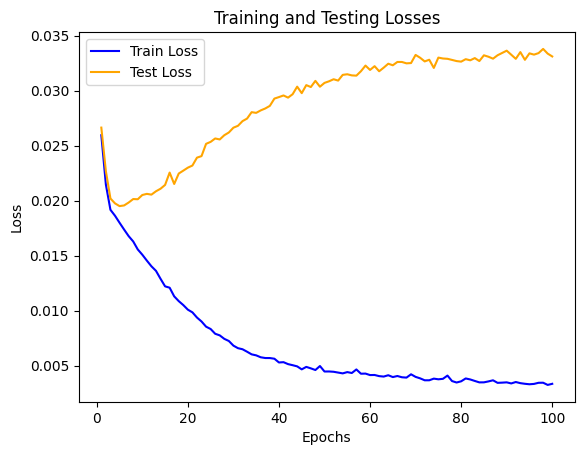

In [28]:
epochs = range(1, len(train_losses) + 1)

# Plot both training and testing losses
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, test_losses, label='Test Loss', color='orange')

# Adding titles and labels
plt.title('Training and Testing Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
    
# Show the plot
plt.show()

## v distribution

### Training Data

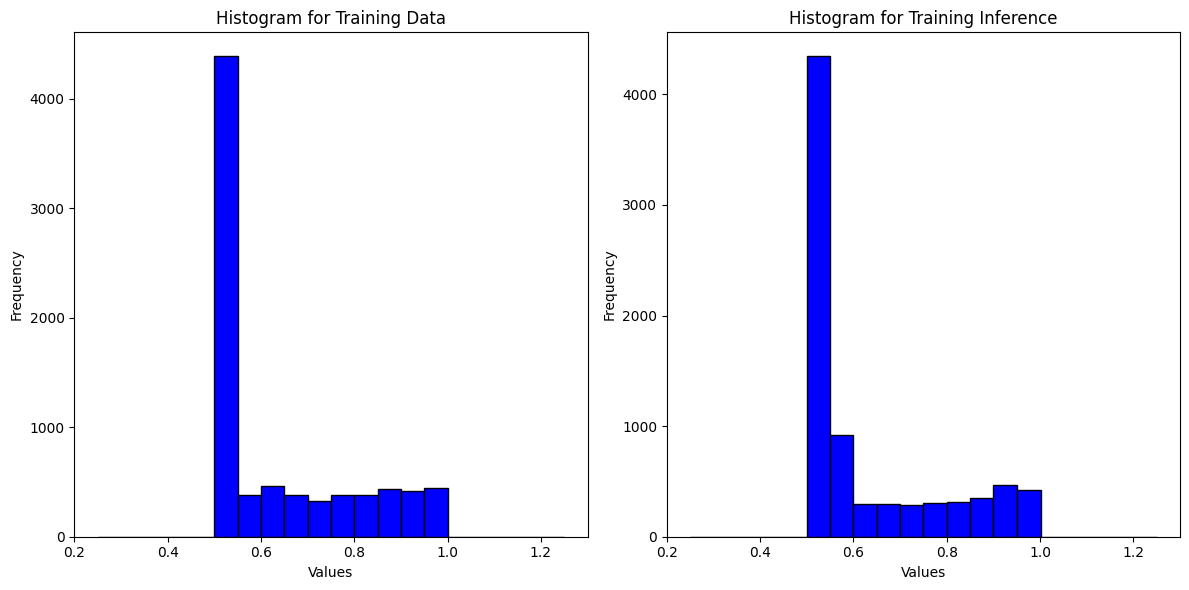

In [30]:
model.eval()

with torch.no_grad():
    train_loader_v = []
    train_infer_v = []
    for Phis, betas, v_opt in train_loader:
        train_loader_v += v_opt.numpy().squeeze().tolist()
        train_infer_v += model(Phis).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(train_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Training Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(train_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Training Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

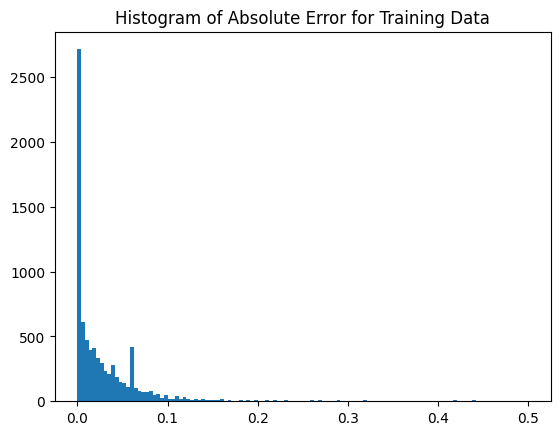

In [31]:
plt.hist(np.abs(np.array(train_loader_v) - np.array(train_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Training Data")
plt.show()

### Test Data

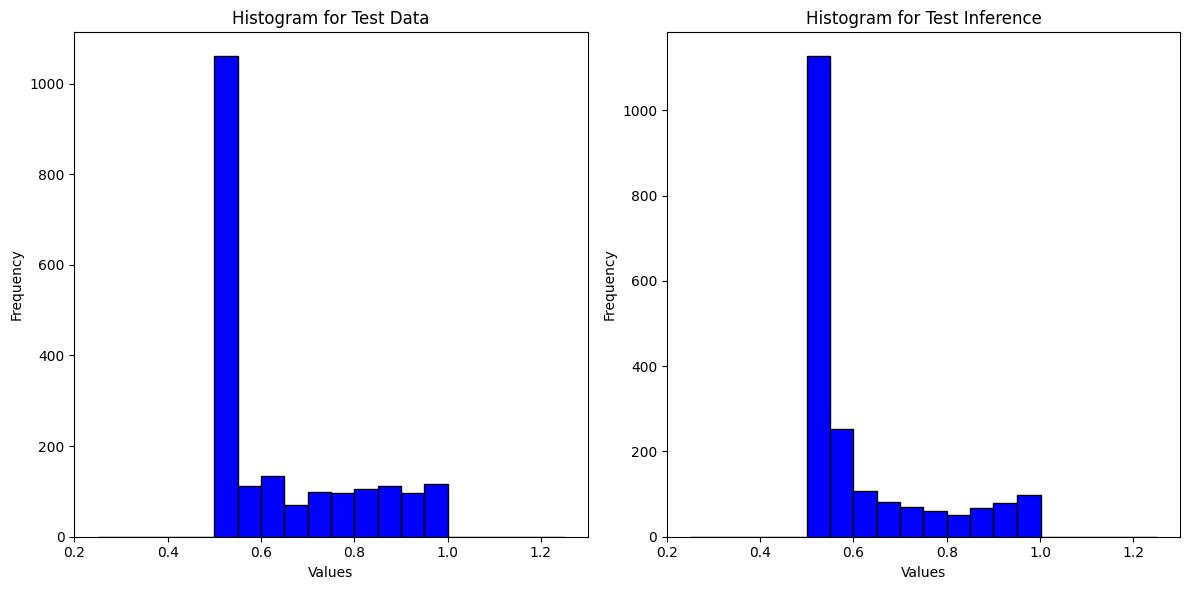

In [32]:
model.eval()

with torch.no_grad():
    test_loader_v = []
    test_infer_v = []
    for Phis, betas, v_opt in test_loader:
        test_loader_v += v_opt.numpy().squeeze().tolist()
        test_infer_v += model(Phis).numpy().squeeze().tolist()

bin_edges = [0.25, 0.3, 0.35, 0.4 , 0.45 , 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.001, 1.05, 1.1, 1.15, 1.2, 1.25]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

N, bins, patches = ax1.hist(test_loader_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax1.set_title('Histogram for Test Data')
ax1.set_xlabel('Values')
ax1.set_ylabel('Frequency')

N, bins, patches = ax2.hist(test_infer_v, bins=bin_edges, edgecolor='black')
for i in range(0, 4+1):
    patches[i].set_facecolor('r')
for i in range(5,15):    
    patches[i].set_facecolor('b')
for i in range(15, len(patches)):
    patches[i].set_facecolor('r')
ax2.set_title('Histogram for Test Inference')
ax2.set_xlabel('Values')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

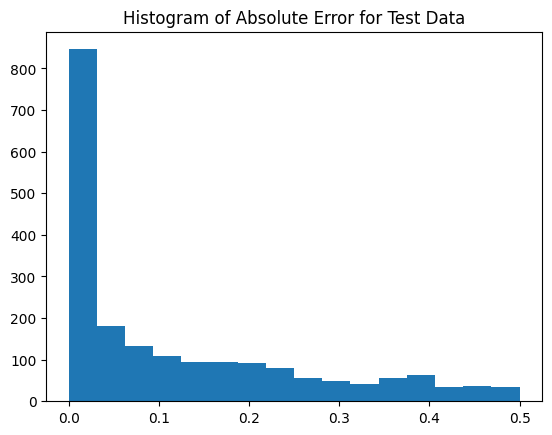

In [33]:
plt.hist(np.abs(np.array(test_loader_v) - np.array(test_infer_v)), bins='auto')
plt.title("Histogram of Absolute Error for Test Data")
plt.show()

## FDR and TPR

In [34]:
data_dir = 'data'
phi_dir = os.path.join(data_dir, 'Phi_mat')
true_actives_dir = os.path.join(data_dir, 'true_actives')

phi_data = [np.loadtxt(os.path.join(phi_dir, f)) 
            for f in os.listdir(phi_dir) if f.startswith('Phi_mat_') and f.endswith('.txt')]
true_actives_data = [np.loadtxt(os.path.join(true_actives_dir, f), dtype=int) - 1  # We substract 1 as they are R indices (starting from 1)
                     for f in os.listdir(true_actives_dir) if f.startswith('true_actives_') and f.endswith('.txt')]

FDRs = []  # or FDPs
TPRs = []  # or TPPs
for phi, true_actives in zip(phi_data, true_actives_data):
    with torch.no_grad():   
        v = model(torch.Tensor(phi)).numpy()[0]
    selected = np.where(phi > v)[0]
    selected_actives = np.intersect1d(selected, true_actives, assume_unique=True)
    selected_null = np.setdiff1d(selected, selected_actives, assume_unique=True)
    FDRs.append(len(selected_null)/max(len(selected), 1))
    TPRs.append(len(selected_actives)/max(len(true_actives), 1))

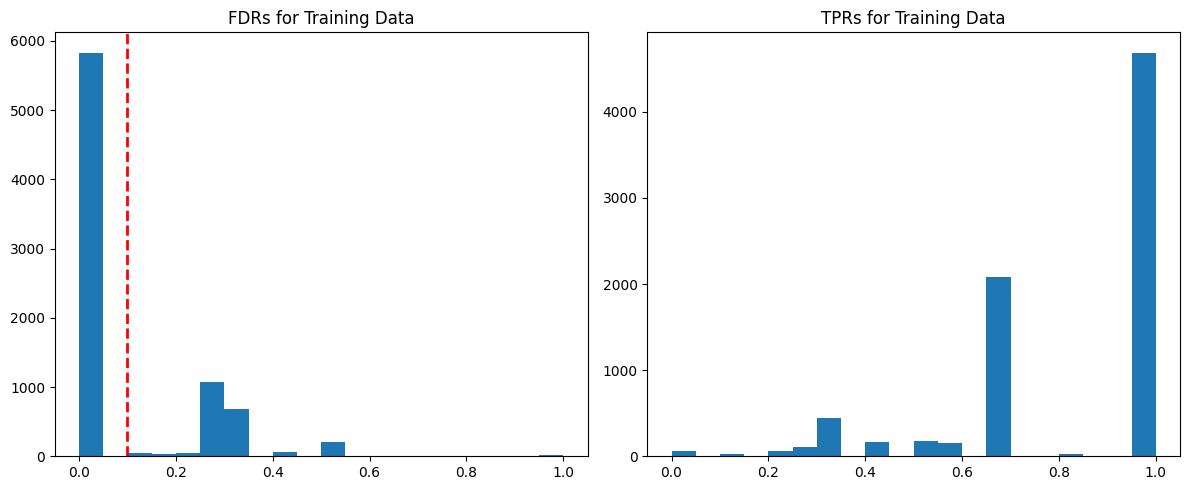

In [35]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[train_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Training Data")

axs[1].hist(np.array(TPRs)[train_indices], bins=bins)
axs[1].set_title("TPRs for Training Data")

plt.tight_layout()
plt.show()

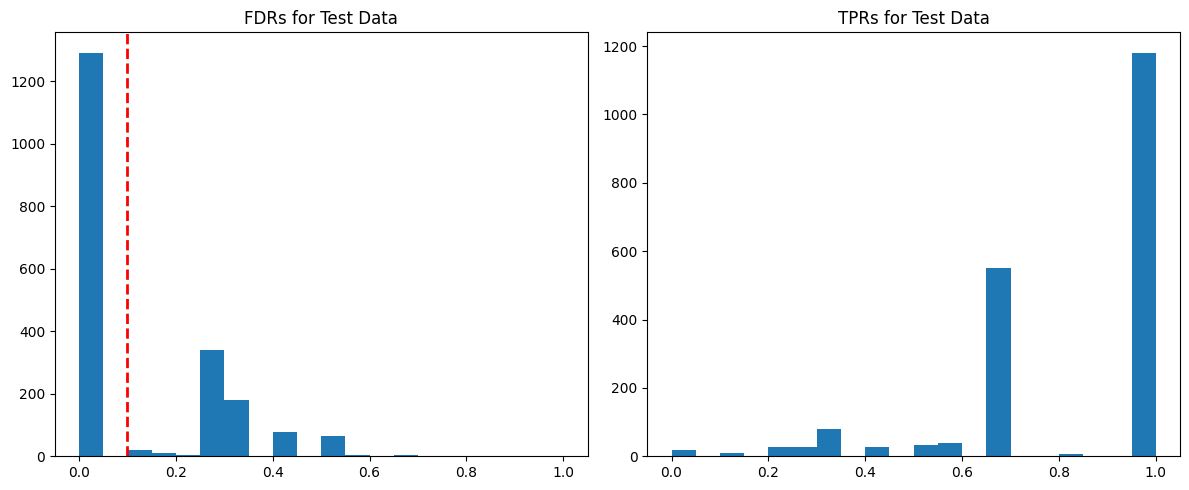

In [36]:
bins = np.arange(0, 1.05, 0.05)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(np.array(FDRs)[test_indices], bins=bins)
axs[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2)
axs[0].set_title("FDRs for Test Data")

axs[1].hist(np.array(TPRs)[test_indices], bins=bins)
axs[1].set_title("TPRs for Test Data")

plt.tight_layout()
plt.show()